<a href="https://colab.research.google.com/github/sharmin133/Rice-Leaf/blob/main/LIME_with_Mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
image_dir = Path('/content/drive/MyDrive/Final Thesis/preprocessing/resize dataset')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy
1,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy
2,/content/drive/MyDrive/Final Thesis/preprocess...,Brownspot
3,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy
4,/content/drive/MyDrive/Final Thesis/preprocess...,Blast


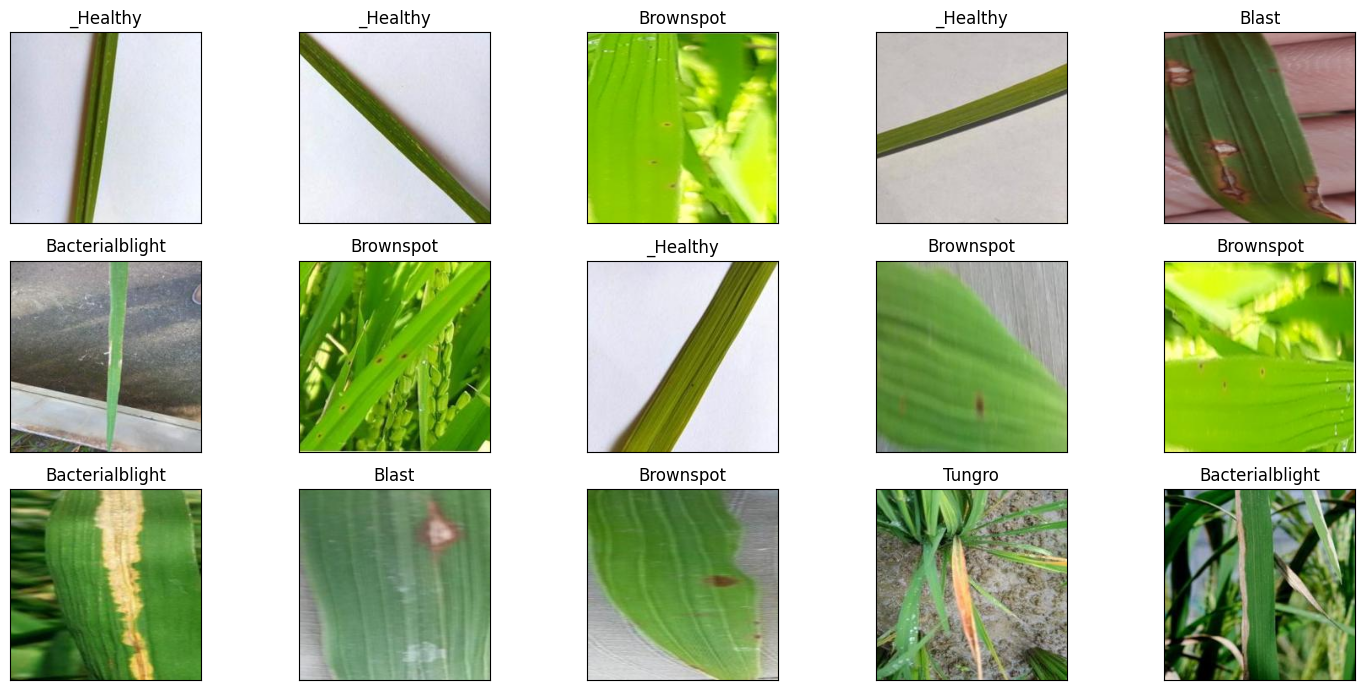

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:

train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96, 96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4145 validated image filenames belonging to 5 classes.
Found 460 validated image filenames belonging to 5 classes.
Found 1152 validated image filenames belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
    input_shape=(96, 96, 3),pooling='avg'

)

pretrained_model.trainable = False

In [ ]:

pretrained_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    verbose=1,
        )

Epoch 1/25
130/130 [==============================] - 1361s 10s/step - loss: 2.9826 - accuracy: 0.7327 - val_loss: 1.7468 - val_accuracy: 0.9478
Epoch 2/25
130/130 [==============================] - 43s 333ms/step - loss: 1.4594 - accuracy: 0.9156 - val_loss: 1.0167 - val_accuracy: 0.9739
Epoch 3/25
130/130 [==============================] - 42s 324ms/step - loss: 0.9138 - accuracy: 0.9472 - val_loss: 0.6518 - val_accuracy: 0.9913
Epoch 4/25
130/130 [==============================] - 45s 348ms/step - loss: 0.6261 - accuracy: 0.9662 - val_loss: 0.4810 - val_accuracy: 0.9848
Epoch 5/25
130/130 [==============================] - 43s 327ms/step - loss: 0.4777 - accuracy: 0.9725 - val_loss: 0.3592 - val_accuracy: 0.9935
Epoch 6/25
130/130 [==============================] - 41s 313ms/step - loss: 0.3961 - accuracy: 0.9742 - val_loss: 0.3080 - val_accuracy: 0.9957
Epoch 7/25
130/130 [==============================] - 43s 325ms/step - loss: 0.3464 - accuracy: 0.9732 - val_loss: 0.2647 - val_ac

In [ ]:
for layer in model.layers:
    print(layer.name)

input_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

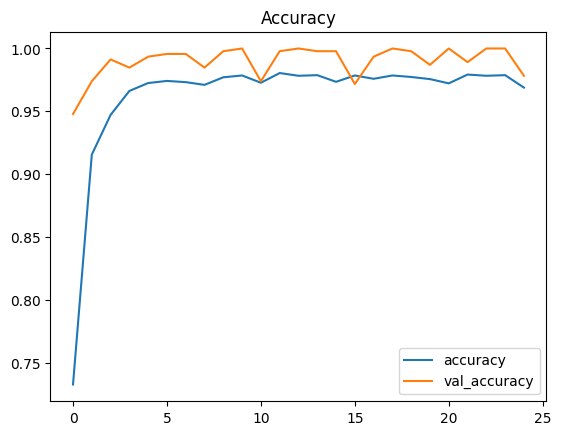

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

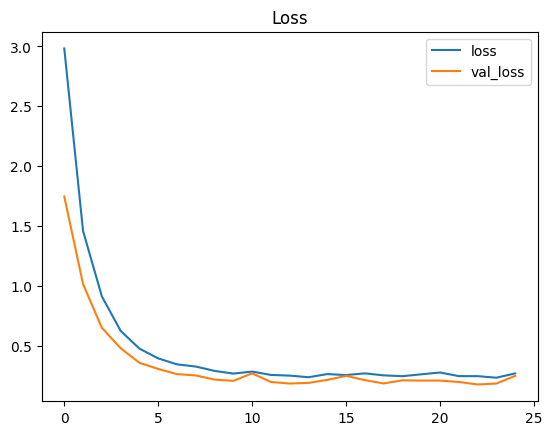

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:

pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

36/36 [==============================] - 358s 10s/step
The first 5 predictions: ['Brownspot', 'Bacterialblight', 'Brownspot', 'Bacterialblight', 'Brownspot']


In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

Bacterialblight       0.98      1.00      0.99       277
          Blast       0.97      1.00      0.99       189
      Brownspot       1.00      0.96      0.98       315
         Tungro       1.00      1.00      1.00        85
       _Healthy       0.99      1.00      1.00       286

       accuracy                           0.99      1152
      macro avg       0.99      0.99      0.99      1152
   weighted avg       0.99      0.99      0.99      1152



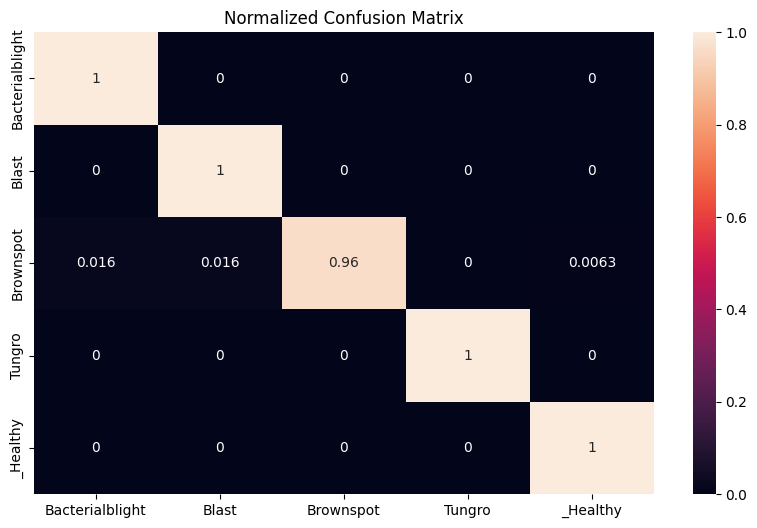

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

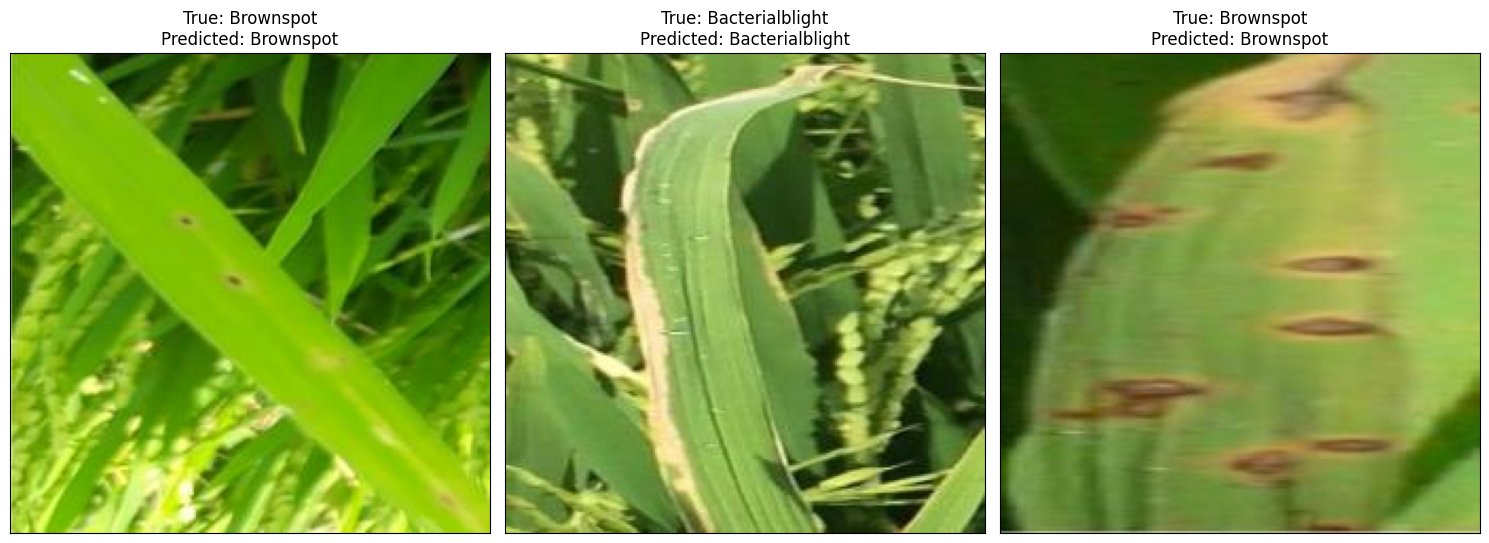

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(test_df):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
!pip install lime
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=45f3362bafaa20832b2bdc921f273bc9a2d29d383011ceb2efc5fbe1280fec3a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import cv2

def generate_lime_explanation(img_path, model, img_size=(96, 96), num_samples=100):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    explainer = lime.lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=5, num_samples=num_samples)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    mask = cv2.resize(mask, (img.size[0], img.size[1]))

    mask_binary = np.where(mask > 0, 1, 0)

    kernel = np.ones((5, 5), np.uint8)
    mask_binary_dilated = cv2.dilate(mask_binary.astype(np.uint8), kernel, iterations=1)

    return mask_binary_dilated


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 130ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 144ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 127ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 118ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 71ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 96ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 118ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step


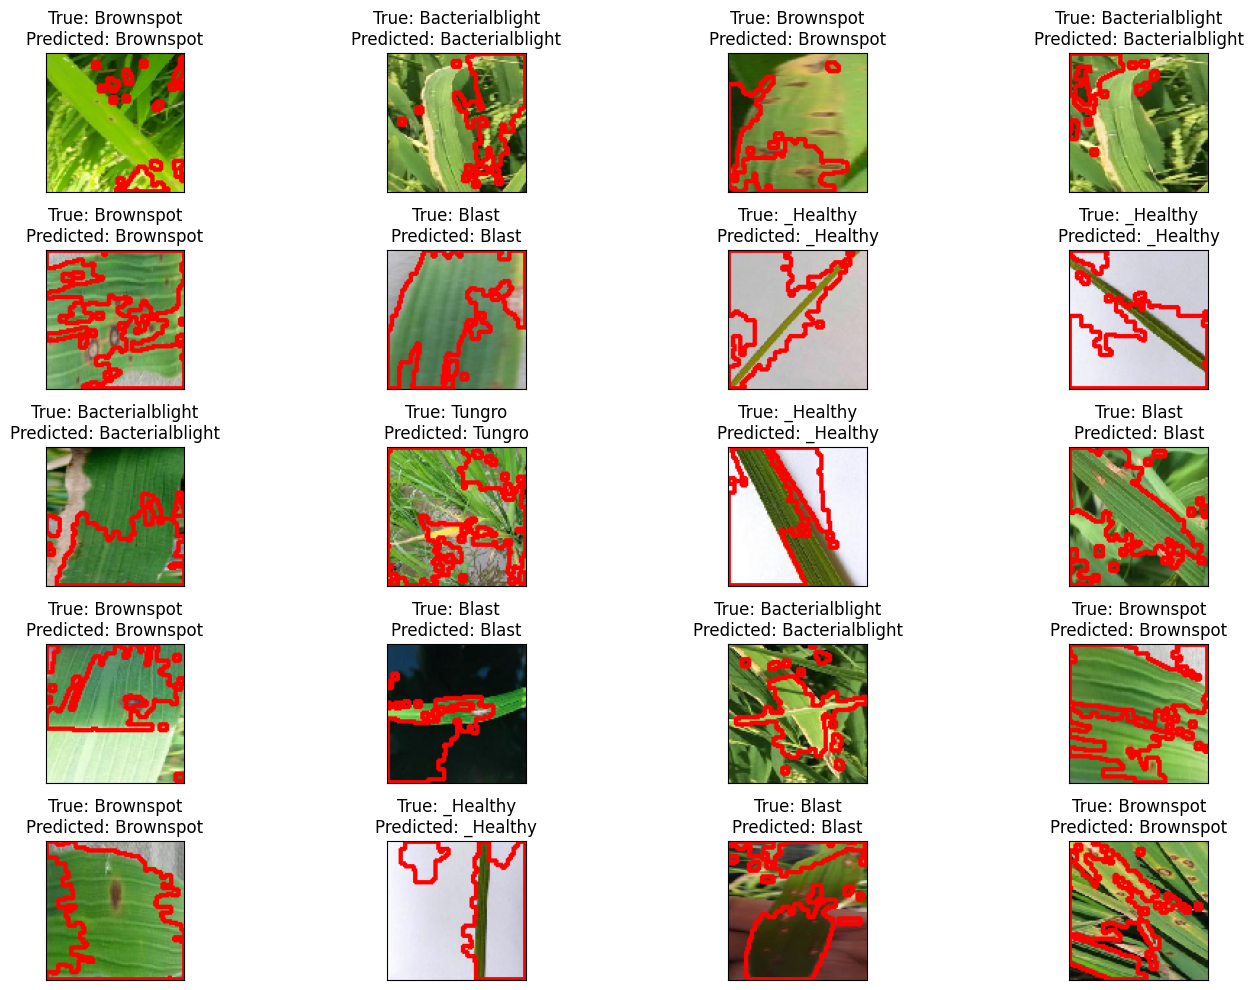

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(96, 96))

    leaf_mask = generate_lime_explanation(img_path, model)
    original_img = np.array(img)
    contours, _ = cv2.findContours(leaf_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(original_img, contours, -1, (255, 0, 0), 2)

    ax.imshow(original_img)
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")

plt.tight_layout()
plt.show()
